In [52]:
#packages
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, cohen_kappa_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from plotnine import *

# Part 0: Data Cleaning

In [53]:
ha_df = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha_df

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [54]:
#drop na values
ha_df = ha_df.dropna()
ha_df.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


# Part 1: Fitting Models

In [55]:
X = ha_df.drop(["output"], axis = 1)
y = ha_df["output"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [56]:
ha_df.dtypes

age        int64
sex        int64
cp         int64
trtbps     int64
chol       int64
restecg    int64
thalach    int64
output     int64
dtype: object

In [57]:
#column transformer function
def model(regression_label, type_of_regression):
    
    """
    transforms columns and outputs a pipeline of the desired kind of regression model
  
    Parameter
    ---------
    regression_label : str
    A string represeting the label of the modeling type
    
    type_of_regression: sklearn function
    A specific function for the modeling type 

    Returns
    -------
    arrays 
    returns the pipeline of the specified type of model
    """
    
    ct = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = "ignore"), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])], remainder = "passthrough")
    
    lr_pipeline = Pipeline(
      [("preprocessing", ct),
      (regression_label, type_of_regression)]
    ).set_output(transform = "pandas")
    
    return lr_pipeline

## K-Nearest Neighbor Model

In [58]:
pipeline_knn = model("knn", KNeighborsClassifier())

In [59]:
#tuning to see which k value is best
k_values = [1, 10, 30, 50, 80]

param = {'knn__n_neighbors': k_values}

#running girdsearchcv to tune to different n_neighbor values
gscv_knn = GridSearchCV(pipeline_knn, param, cv = 5, scoring='roc_auc')
gscv_fitted_knn = gscv_knn.fit(X, y)

In [60]:
#creating dataframe for n_neighbor values and roc_auc scores
n_neighbor_df = pd.DataFrame(gscv_fitted_knn.cv_results_)
n_neighbor_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019339,0.009943,0.020276,0.016289,1,{'knn__n_neighbors': 1},0.743333,0.692971,0.656499,0.759310,0.659310,0.702285,0.042348,5
1,0.015513,0.003816,0.014509,0.003145,10,{'knn__n_neighbors': 10},0.805333,0.856101,0.814324,0.875172,0.682759,0.806738,0.067157,4
2,0.017251,0.001940,0.017614,0.006201,30,{'knn__n_neighbors': 30},0.809333,0.856101,0.848143,0.884138,0.705517,0.820647,0.062333,2
3,0.010739,0.000601,0.010009,0.000568,50,{'knn__n_neighbors': 50},0.792000,0.863395,0.862069,0.899310,0.694483,0.822251,0.072741,1
4,0.011291,0.001754,0.009684,0.000200,80,{'knn__n_neighbors': 80},0.778000,0.853448,0.845491,0.882069,0.708966,0.813595,0.062464,3


In [61]:
#sorted table of number of neighbors and the roc_auc score
n_neighbor_df = n_neighbor_df[["param_knn__n_neighbors", "mean_test_score"]] 
n_neighbor_df.sort_values(by = "mean_test_score", ascending = False)

,param_knn__n_neighbors,mean_test_score
3,50,0.822251
2,30,0.820647
4,80,0.813595
1,10,0.806738
0,1,0.702285


For a knn model, it's best to have 50 neighbors. The ROC AUC score is 0.822.

In [62]:
#fit pipeline on training again where knn value is 50
pipeline_knn_50 = model("knn", KNeighborsClassifier(n_neighbors = 50))
fitted_pipeline_knn_50 = pipeline_knn_50.fit(X, y)
fitted_pipeline_knn_50

#predict output
y_preds_knn50 = fitted_pipeline_knn_50.predict(X)
y_preds_knn50

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1])

In [63]:
#confusion matrix
conf_matrix_knn50 = confusion_matrix(y, y_preds_knn50)
pd.DataFrame(conf_matrix_knn50)

,0,1
0,101,26
1,40,106


## Decision Tree

In [64]:
pipeline_dt = model("dt", DecisionTreeClassifier())
pipeline_dt

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach'])])),
                ('dt', DecisionTreeClassifier())])

In [65]:
#find best branch number by tuning
max_depth = [1, 5, 10, 30, 50]

param = {'dt__max_depth': max_depth}

#running girdsearchcv to tune to different n_neighbor values
gscv_dt = GridSearchCV(pipeline_dt, param, cv = 5, scoring='roc_auc')
gscv_fitted_dt = gscv_dt.fit(X, y)

In [66]:
#creating dataframe for n_neighbor values and roc_auc scores
max_depth_df = pd.DataFrame(gscv_fitted_dt.cv_results_)
max_depth_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023064,0.008598,0.022121,0.022283,1,{'dt__max_depth': 1},0.796667,0.746684,0.727454,0.776552,0.719310,0.753333,0.029286,1
1,0.011797,0.000548,0.008541,0.000841,5,{'dt__max_depth': 5},0.684667,0.709549,0.751326,0.755172,0.660690,0.712281,0.036867,2
2,0.011311,0.000427,0.008763,0.000503,10,{'dt__max_depth': 10},0.673333,0.694960,0.696950,0.750345,0.664828,0.696083,0.029802,4
3,0.010771,0.000438,0.008613,0.000782,30,{'dt__max_depth': 30},0.673333,0.744695,0.675729,0.739310,0.684828,0.703579,0.031652,3
4,0.010696,0.000908,0.009110,0.002345,50,{'dt__max_depth': 50},0.673333,0.744695,0.622016,0.736552,0.662069,0.687733,0.046503,5


In [67]:
#sorted table of max_depth and the roc_auc score
max_depth_df = max_depth_df[["param_dt__max_depth", "mean_test_score"]] 
max_depth_df.sort_values(by = "mean_test_score", ascending = False)

,param_dt__max_depth,mean_test_score
0,1,0.753333
1,5,0.712281
3,30,0.703579
2,10,0.696083
4,50,0.687733


The best decision tree model is when the max_depth number is 1. The ROC AUC score is 0.753.

In [68]:
#fit pipeline again where max_depth = 1
pipeline_dt5 = model("dt", DecisionTreeClassifier(max_depth = 1))
fitted_pipeline_dt5 = pipeline_dt5.fit(X, y)
fitted_pipeline_dt5

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach'])])),
                ('dt', DecisionTreeClassifier(max_depth=1))])

In [69]:
#predict output
y_preds_dt5 = fitted_pipeline_dt5.predict(X)
y_preds_dt5

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1])

In [70]:
#confusion matrix
conf_matrix_dt5 = confusion_matrix(y, y_preds_dt5)
pd.DataFrame(conf_matrix_dt5)

,0,1
0,94,33
1,34,112


## Logistic Regression

In [71]:
#run logistic regression
pipeline_log = model("log_reg", LogisticRegression())

#different penalties (l1 = lasso, l2 = ridge, elastic_net)
#make sure to also include l1_ratio values for elastic_net

param_grid = [
    {'log_reg__penalty': ['l1', 'l2'], 
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['liblinear', 'saga']},  # 'liblinear' and 'saga' support 'l1' and 'l2'

    {'log_reg__penalty': ['elasticnet'], 
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['saga'],  # 'saga' supports 'elasticnet'
     'log_reg__l1_ratio': [0, 0.5, 1]},  # Relevant for 'elasticnet' only

    {'log_reg__penalty': ['none'], 
     'log_reg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}  # These solvers support no penalty
]

#running girdsearchcv to tune to different n_neighbor values
gscv_log = GridSearchCV(pipeline_log, param_grid, cv = 5, scoring='roc_auc')
gscv_fitted_log = gscv_log.fit(X, y)

/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter w

In [72]:
#creating dataframe for n_neighbor values and roc_auc scores
log_reg_df = pd.DataFrame(gscv_fitted_log.cv_results_)
log_reg_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log_reg__C,param_log_reg__penalty,param_log_reg__solver,param_log_reg__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026129,0.010221,0.014643,0.002188,0.001,l1,liblinear,NaN,"{'log_reg__C': 0.001, 'log_reg__penalty': 'l1'...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,33
1,0.018695,0.002573,0.015878,0.004035,0.001,l1,saga,NaN,"{'log_reg__C': 0.001, 'log_reg__penalty': 'l1'...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,33
2,0.013183,0.002950,0.010521,0.002733,0.001,l2,liblinear,NaN,"{'log_reg__C': 0.001, 'log_reg__penalty': 'l2'...",0.745333,0.874005,0.877984,0.856552,0.688276,0.808430,0.077294,31
3,0.011850,0.000762,0.008639,0.000254,0.001,l2,saga,NaN,"{'log_reg__C': 0.001, 'log_reg__penalty': 'l2'...",0.750667,0.880637,0.879310,0.862069,0.688276,0.812192,0.078508,29
4,0.009778,0.000270,0.007529,0.000191,0.01,l1,liblinear,NaN,"{'log_reg__C': 0.01, 'log_reg__penalty': 'l1',...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,33


In [73]:
#narrow down dataframe
log_df = log_reg_df[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver", 
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
log_df.sort_values(by = "mean_test_score", ascending = False).head()

,param_log_reg__C,param_log_reg__l1_ratio,param_log_reg__solver,param_log_reg__penalty,mean_test_score,rank_test_score
31,1,1,saga,elasticnet,0.868394,1
13,1,NaN,saga,l1,0.868394,1
12,1,NaN,liblinear,l1,0.865981,3
30,1,0.5,saga,elasticnet,0.865433,4
29,1,0,saga,elasticnet,0.864368,5


Best logistic regression model is when elastic net is used. The ideal lambda value is 1, alpha value is 1, and solver = saga. The ROC AUC value is 0.868.

In [74]:
#fit model again on training
pipeline_log_real = model("log_reg", LogisticRegression(penalty = "elasticnet", C = 1, l1_ratio=1, solver = "saga"))
fitted_pipeline_log_real = pipeline_log_real.fit(X, y)
fitted_pipeline_log_real

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach'])])),
                ('log_reg',
                 LogisticRegression(C=1, l1_ratio=1, penalty='elasticnet',
                                    solver='saga'))])

In [75]:
#predict
#predict output
y_preds_log = fitted_pipeline_log_real.predict(X)
y_preds_log

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1])

In [76]:
#confusion matrix
conf_matrix_log = confusion_matrix(y, y_preds_log)
pd.DataFrame(conf_matrix_log)

,0,1
0,95,32
1,24,122


In [77]:
#coefficients
coeff_log = fitted_pipeline_log_real.named_steps["log_reg"].coef_
coeff_log = coeff_log.flatten()

feature_names = fitted_pipeline_log_real[:-1].get_feature_names_out()

coeff_var_df = pd.DataFrame({"variable_name": feature_names,
                                  "coefficients": coeff_log})
coeff_var_df
coeff_var_df.sort_values(by = "coefficients", ascending = False)

,variable_name,coefficients
0,dummify__sex_0,1.421378
12,standardize__thalach,0.757697
7,dummify__restecg_1,0.286610
3,dummify__cp_1,0.053733
4,dummify__cp_2,0.000000
5,dummify__cp_3,0.000000
6,dummify__restecg_0,0.000000
8,dummify__restecg_2,0.000000
9,standardize__age,-0.222192
11,standardize__chol,-0.254978


Interpreting the coefficients:
For positive coefficients: these variables have a positive association with the outcome (being at risk of having a heart attack). For example, sex 0 increases their log odds of having an exercise-induced heart attack by 1.421328. For negative coefficients: these variables have a negative association with the outcome. For example, lower values of chest pain decreases their chance of getting a heart attack. 

One thing to mention is that there seems to be a discrepancy between the variable chest pain and the true meaning with chest pain. The coefficients show that having typical angina has a negative association with the outcome. When a patient has chest pain, they are labeled as having a low risk of having a heart attack. This does not make sense. Usually, those with angina have a high risk of having a heart attack, since it is a "tell-tale" symptom of having a heart attack. Further analysis is needed to determine the relationship between chest pain and the outcome. This applies for the cholesterol and age variables as well; typically when cholesterol levels and age increase, the risk of having a heart attack increases as well. However, the coefficient is slightly negative. Statistical analysis is needed to determine if the cholesterol variable has a significant association with the outcome.

## Interpretation

The most important predictors in predicting heart attack risk are sex, thalach, chest pain level, cholesterol, age, and trtbps. Among these variables, chest pain, sex, and thalach are the most influential, since their coefficients are the most drastic. 

## ROC Curve

In [78]:
#getting probabilities for each model

#knn
y_scores_knn = fitted_pipeline_knn_50.predict_proba(X)[:, 1]
#decision tree
y_scores_dt = fitted_pipeline_dt5.predict_proba(X)[:, 1]
#logistic regression
y_scores_log = fitted_pipeline_log_real.predict_proba(X)[:, 1]
y_scores_log

array([0.48969428, 0.90705677, 0.86152396, 0.67646331, 0.21344871,
       0.88573402, 0.86116654, 0.63972455, 0.80204091, 0.25581781,
       0.90835538, 0.80846915, 0.89181595, 0.96515496, 0.95240848,
       0.71318196, 0.33989964, 0.89723637, 0.87319134, 0.43265972,
       0.86507328, 0.6414019 , 0.64090392, 0.7872595 , 0.67200892,
       0.9865832 , 0.21083357, 0.88681228, 0.47452843, 0.95246262,
       0.9492032 , 0.64116437, 0.85131709, 0.73543627, 0.8440016 ,
       0.82832157, 0.32820537, 0.53709732, 0.77749965, 0.78528525,
       0.8149132 , 0.6353637 , 0.80614564, 0.66881954, 0.91318617,
       0.13251201, 0.60445752, 0.99025946, 0.93937716, 0.51338221,
       0.50939785, 0.89939927, 0.60379066, 0.73566712, 0.90520542,
       0.63990952, 0.68327106, 0.91630101, 0.76632955, 0.97093655,
       0.87390898, 0.77682581, 0.60272291, 0.83655537, 0.95041153,
       0.36836422, 0.97616572, 0.74681071, 0.73177383, 0.89330395,
       0.90466284, 0.74089354, 0.95226171, 0.72766461, 0.55948

In [79]:
#calculating true positive rates (tpr) and false positive rates (fpr) at various thresholds

#knn
fpr_knn, tpr_knn, threshold = roc_curve(y, y_scores_knn)

#decision tree
fpr_dt, tpr_dt, threshold = roc_curve(y, y_scores_dt)

#logisitic regression
fpr_log, tpr_log, threshold = roc_curve(y, y_scores_log)


In [80]:
#calculating roc auc curve

#knn
roc_auc_knn = auc(fpr_knn, tpr_knn)

#decision tree
roc_auc_dt = auc(fpr_dt, tpr_dt)

#logistic regression
roc_auc_log = auc(fpr_log, tpr_log)


In [81]:
#pandas dataframe for knn
roc_df_knn = pd.DataFrame({"fpr_knn": fpr_knn,
                       "tpr_knn": tpr_knn})
roc_df_knn.head()

#pandas dataframe for decision tree
roc_df_dt = pd.DataFrame({"fpr_dt": fpr_dt,
                       "tpr_dt": tpr_dt})
roc_df_dt.head()

#pandas dataframe for logistic regression
roc_df_log = pd.DataFrame({"fpr_log": fpr_log,
                       "tpr_log": tpr_log})
roc_df_log.head()
                       

,fpr_log,tpr_log
0,0.000000,0.000000
1,0.000000,0.006849
2,0.000000,0.109589
3,0.007874,0.109589
4,0.007874,0.246575


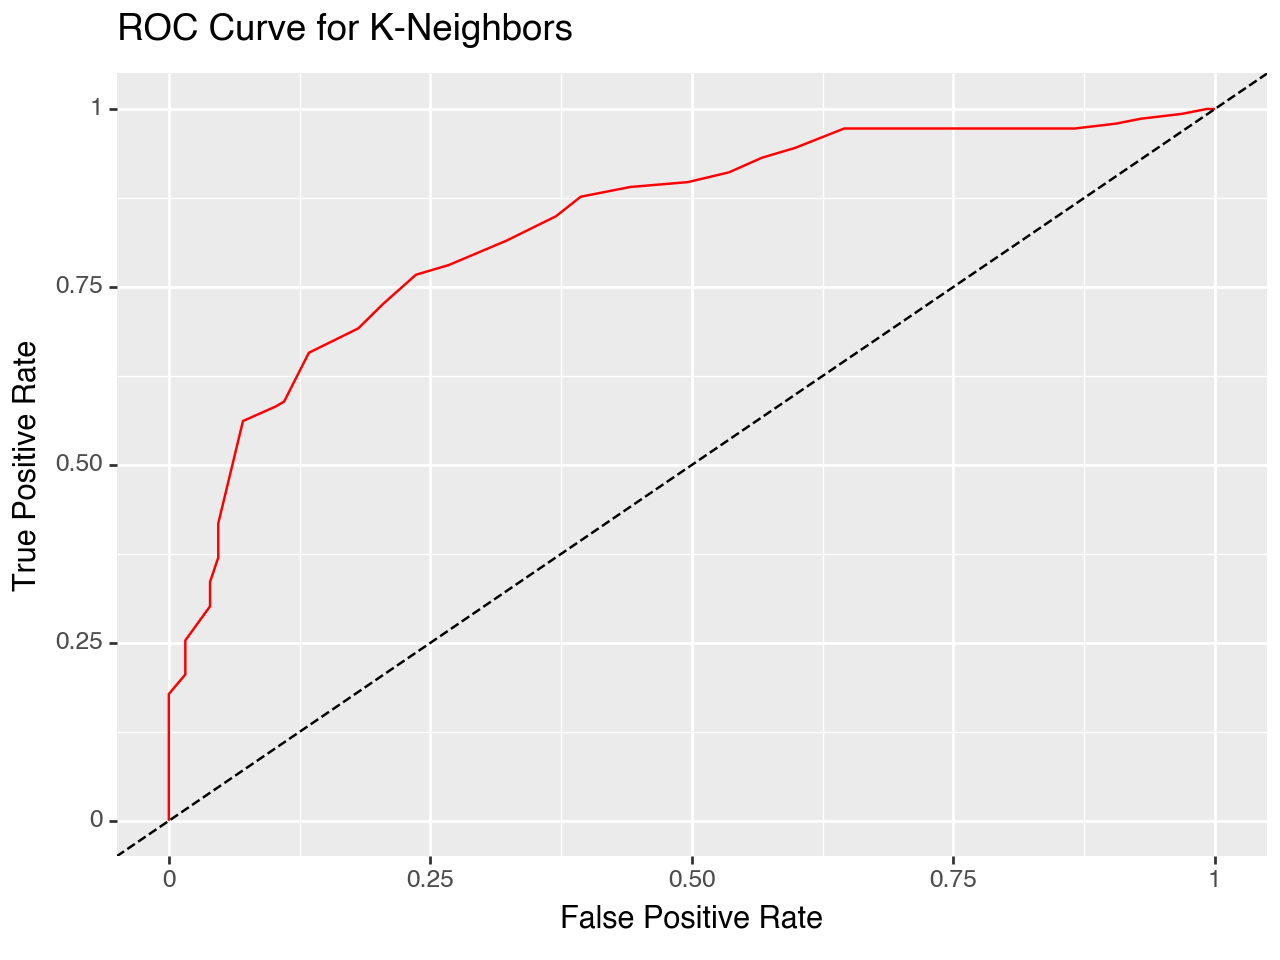

<Figure Size: (640 x 480)>

In [82]:
#roc graph for knn
knn_plot = (ggplot(roc_df_knn, aes(x = "fpr_knn", y = "tpr_knn"))
 + geom_line(color = "red")
 + geom_abline(linetype='dashed')
 + xlab("False Positive Rate")
 + ylab("True Positive Rate")
 + ggtitle("ROC Curve for K-Neighbors"))
knn_plot

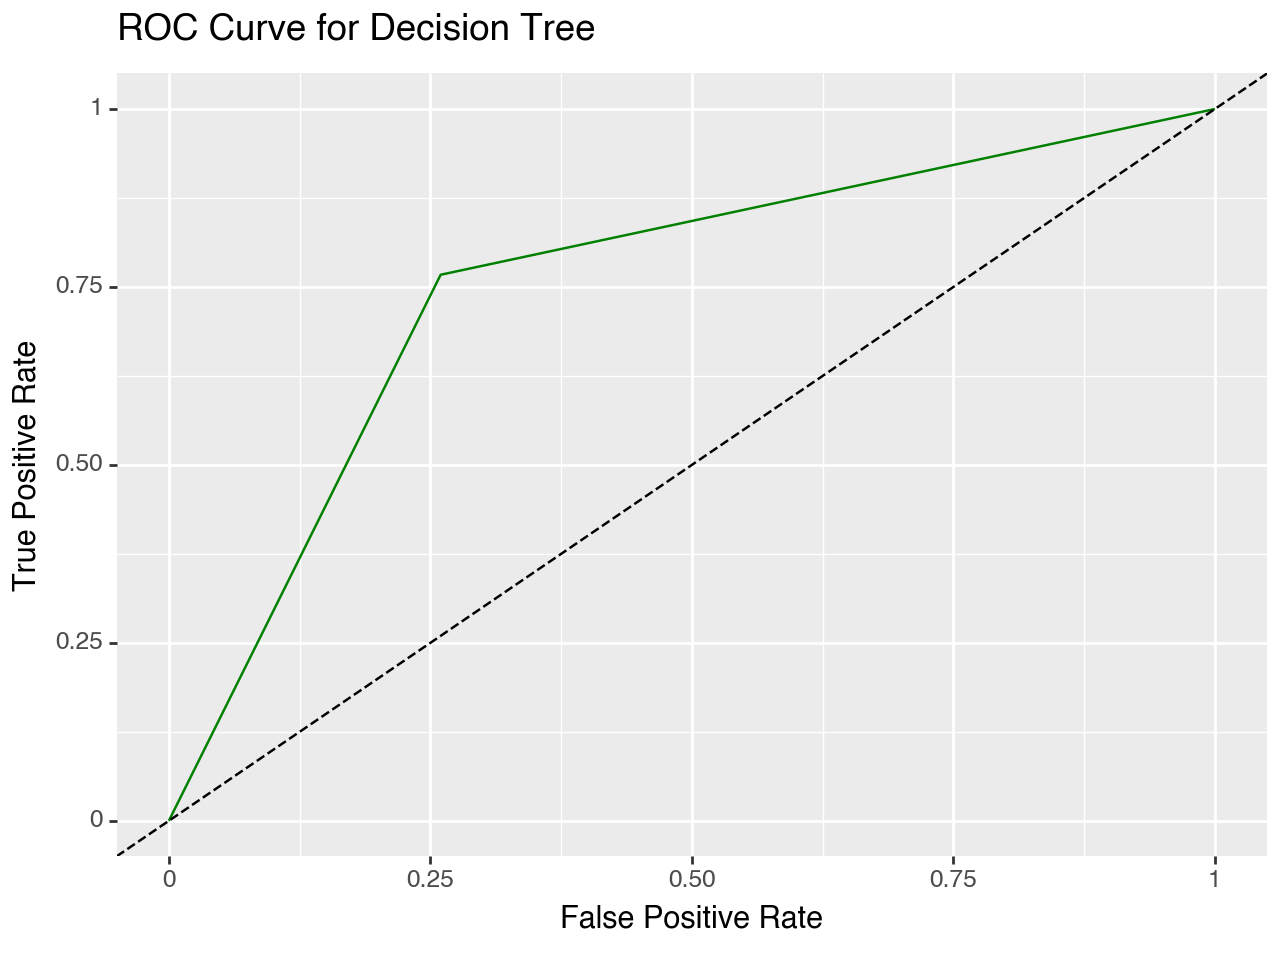

<Figure Size: (640 x 480)>

In [83]:
#roc graph for knn
dt_plot = (ggplot(roc_df_dt, aes(x = "fpr_dt", y = "tpr_dt"))
 + geom_line(color = "green")
 + geom_abline(linetype='dashed')
 + xlab("False Positive Rate")
 + ylab("True Positive Rate")
 + ggtitle("ROC Curve for Decision Tree"))
dt_plot

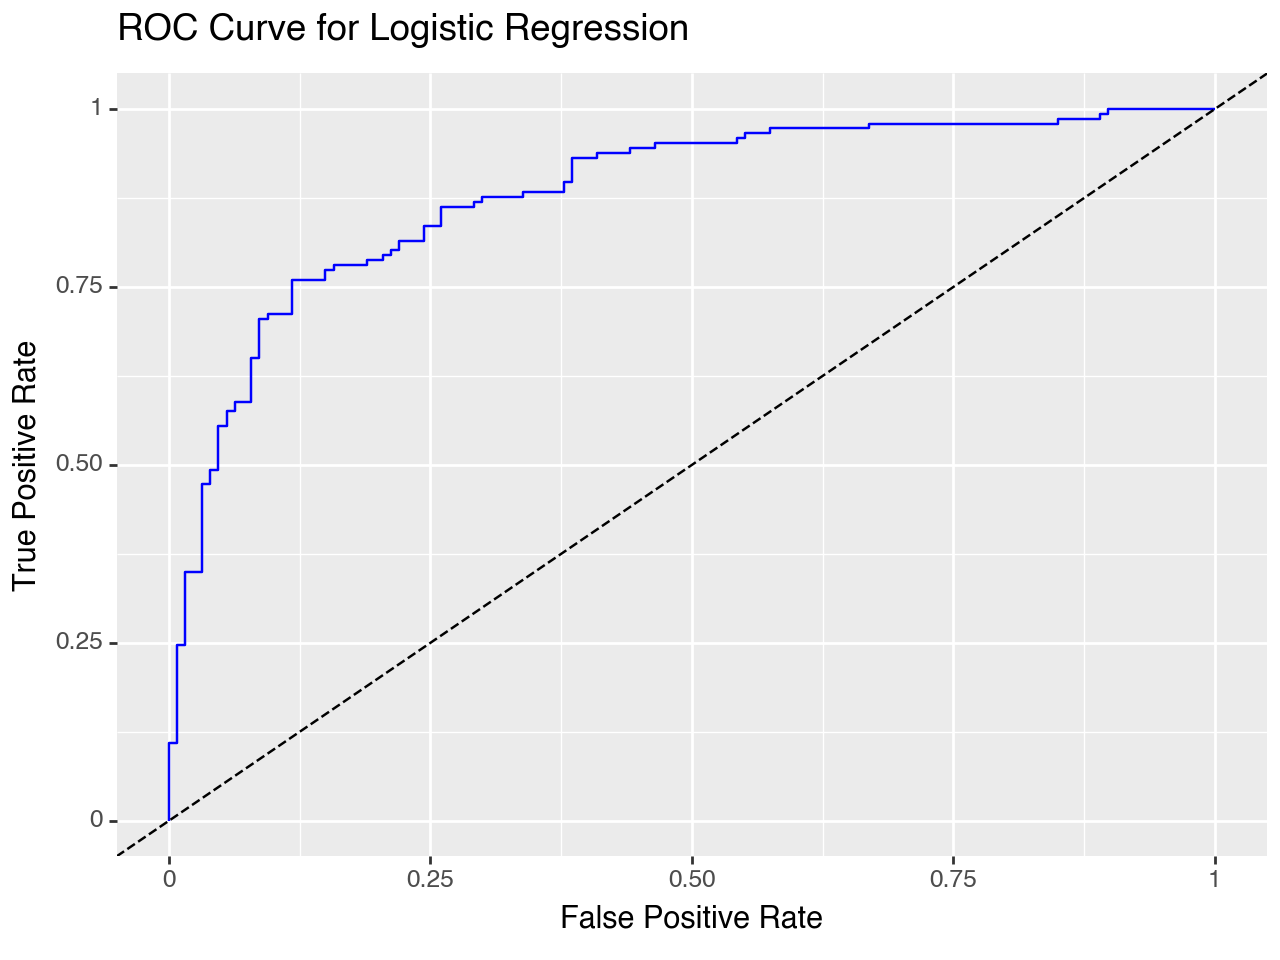

<Figure Size: (640 x 480)>

In [84]:
#roc graph for log
log_plot = (ggplot(roc_df_log, aes(x = "fpr_log", y = "tpr_log"))
 + geom_line(color = "blue")
 + geom_abline(linetype='dashed')
 + xlab("False Positive Rate")
 + ylab("True Positive Rate")
 + ggtitle("ROC Curve for Logistic Regression"))
log_plot

# Part 2: Metrics

## True Positive Rate/Recall/Sensitivity: of all the cases that truly got a heart attack, how many were predicted/classified to have a heart attack?

In [85]:
#knn 
# pd.DataFrame(conf_matrix_knn50)

# true_positive_rate_knn = 106/(106+40)
# true_positive_rate_knn

recall_knn = cross_val_score(pipeline_knn, X, y, cv = 5, scoring='recall')
recall_knn.mean()

0.685287356321839

In [86]:
#decision tree
# pd.DataFrame(conf_matrix_dt5)

# true_positive_rate_dt = 22/(22+15)
# true_positive_rate_dt

recall_dt = cross_val_score(pipeline_dt, X, y, cv = 5, scoring='recall')
recall_dt.mean()

0.664367816091954

In [87]:
#logistic regression

# pd.DataFrame(conf_matrix_log)

# true_positive_rate_log = 24/(13+24)
# true_positive_rate_log

recall_log = cross_val_score(pipeline_log_real, X, y, cv = 5, scoring='recall')
recall_log.mean()

/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


0.8154022988505748

## Precision/Positive Predictive Value: Of all the observations classified as at risk of a heart attack, how many of them truly had a heart attack?

In [88]:
#knn 
# pd.DataFrame(conf_matrix_knn50)

# precision_knn = 18/(18+8)
# precision_knn

precision_knn = cross_val_score(pipeline_knn, X, y, cv = 5, scoring='precision')
precision_knn.mean()

0.7287975763782215

In [89]:
#decision tree
# pd.DataFrame(conf_matrix_dt5)

# precision_dt = 22/(22+10)
# precision_dt

precision_dt = cross_val_score(pipeline_dt, X, y, cv = 5, scoring='precision')
precision_dt.mean()

0.7262427227944469

In [90]:
#logistic regression

# pd.DataFrame(conf_matrix_log)

# precision_log = 24/(24+9)
# precision_log

precision_log = cross_val_score(pipeline_log_real, X, y, cv = 5, scoring='precision')
precision_log.mean()

/Users/conniechou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


0.7965130338056778

## True Negative Rate/Specificity/Negative Predictive Value: Of all the observations classified as NOT at risk of having a heart attack, how many truly did not get a heart attack?

In [116]:
#knn 
pd.DataFrame(conf_matrix_knn50)

true_neg_knn = 101/(101+40)
true_neg_knn



0.7163120567375887

In [117]:
#decision tree
pd.DataFrame(conf_matrix_dt5)

true_neg_knn = 94/(94+34)
true_neg_knn

0.734375

In [118]:
#logistic regression
pd.DataFrame(conf_matrix_log)

true_neg_log = 95/(95+24)
true_neg_log

0.7983193277310925

# Part 3: Discussion

Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.
- For this scenario, the metric used would be the true negative rate. The hospital wants to make sure those that were classified as low risk actually did not have a heart attack. Ideally, this percentage of classifying at low risk patients would want to be high to avoid severe lawsuits.
- I would recommend the logistic regression model to the hospital. It gave the highest percentage of the true negative rate, and it is above 50%. There is a higher chance of being correct with the at-low risk patients.
- The score we would expect for the chosen metric is 79.8%.

Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.
- For this scenario, the metric used would be precision. Out of the patients that were diagnosed of having a high risk of having a heart attack, we would want a high perecentage of those patients to truly have the high risk/have a real heart attack so the hospital doesn't waste any bed space. 
- I would recommend the logistic regression model to the hospital. It gave the highest percentage of precision, and it is above 50%. There is a higher chance of being correct with those that were classified as having a high-risk of having a heart attack.
- The score we would expect for the chosen metric is 79.7%.

Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.
- For this scenario, the metric used would be recall, or the true positive rate. To study the root causes of heart attacks, the hospital would need to look at patients who already had a heart attack and find similarities between the patients to figure out what causes heart attacks. Evidence is needed to find the root cause.
- I would recommend the logistic regression model to the hospital. It gave the highest percentage of the true positive rate and it is above 50%. There is a higher chance of figuring out the root cause of heart attacks with the logistic model.
- The score we would expect for the chosen metric is 81.5%.

Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.
- For this scenario, the metric used would be recall, or the true positive rate. If the hospital wants to compare the new batch of doctor's performance with a predicted value of their performance, the hospital would use the true positive rate. The hospital wants to "recall" to see if they get a similar answer as their true value.
- I would recommend the logistic regression model to the hospital. It gave the highest percentage of the true positive rate and it is above 50%. There is a higher chance of figuring out the root cause of heart attacks with the logistic model.
- The score we would expect for the chosen metric is 81.5%.


# Part 4: Validation

In [94]:
#for each model, predict with validation set
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [95]:
X_val = ha_validation.drop(["output"], axis = 1)
y_val = ha_validation["output"]

## KNN

In [96]:
#use knn model to predict with validation set
y_preds_knn_val = fitted_pipeline_knn_50.predict(X_val)
y_preds_knn_val

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [97]:
#knn confusion matrix
conf_matrix_knn_val = confusion_matrix(y_val, y_preds_knn_val)
pd.DataFrame(conf_matrix_knn_val)

,0,1
0,11,0
1,9,10


In [98]:
#ROC AUC score
roc_auc_knn = roc_auc_score(y_val, y_preds_knn_val)
roc_auc_knn

0.763157894736842

In [99]:
#recall
recall_val_knn = 9/(10+9)
recall_val_knn

0.47368421052631576

In [100]:
#precision
precision_val_knn = 9/(9+2)
precision_val_knn

0.8181818181818182

## Decision Tree

In [101]:
#use decision tree to predict validation set
y_preds_dt_val = fitted_pipeline_dt5.predict(X_val)
y_preds_dt_val

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [102]:
#knn confusion matrix
conf_matrix_dt_val = confusion_matrix(y_val, y_preds_dt_val)
pd.DataFrame(conf_matrix_dt_val)

,0,1
0,10,1
1,5,14


In [103]:
#ROC AUC score
roc_auc_dt = roc_auc_score(y_val, y_preds_dt_val)
roc_auc_dt

0.8229665071770335

In [104]:
#recall
recall_val_dt = 10/(10+9)
recall_val_dt

0.5263157894736842

In [105]:
#precision
precision_val_dt = 10/(10+4)
precision_val_dt

0.7142857142857143

## Logistic Regression

In [106]:
#use log reg to predict validation set
y_preds_log_val = fitted_pipeline_log_real.predict(X_val)
y_preds_log_val

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [107]:
#knn confusion matrix
conf_matrix_log_val = confusion_matrix(y_val, y_preds_log_val)
pd.DataFrame(conf_matrix_log_val)

,0,1
0,9,2
1,5,14


In [108]:
#ROC AUC score
roc_auc_log = roc_auc_score(y_val, y_preds_log_val)
roc_auc_log

0.777511961722488

In [109]:
#recall
recall_val_log = 14/(14+5)
recall_val_log

0.7368421052631579

In [110]:
#precision
precision_val_log = 14/(14+3)
precision_val_log

0.8235294117647058

My logistic regression model is still the best. This matches my results from part 1. The roc auc score is highest for the logistic regression model.

# Part 5: Cohen's Kappa

In [111]:
#cohen's kappa information: https://datatab.net/tutorial/cohens-kappa
#cohen's kappa: measuring agreement between categorical binary variables (1 and 0)
#this agreement is called "inter-rater reliability". measures reliability of two raters measuring the same thing
#if irr is high, then the two raters are in agreement
#HOWEVER, IT DOES NOT TELL YOU IF YOU ARE CORRECT (aka cannot tell u if ur are precise to the true value)
#you don't know the true value

In [113]:
#knn cohen's kappa
knn_ck = cohen_kappa_score(y, y_preds_knn50)
knn_ck

0.5175903614457831

In [114]:
#decision tree cohen's kappa
dt_ck = cohen_kappa_score(y, y_preds_dt5)
dt_ck

0.5070209956068242

In [115]:
#logistic regression cohen's kappa
log_reg_ck = cohen_kappa_score(y, y_preds_log)
log_reg_ck

0.5860500379075056

The rule of thumb for cohen's kappa coefficient is the higher the value, the better the inter-rater reliability; we want this value to be as high as possible to have a model that will predict well with future data. Out of the models, the logistic regression model did the best again. This makes sense because it has the best recall and precision scores as well; it has a higher probability of predicting correctly and being correct with a predicted value. The logistic regression model has less differences between the real data and the predicted data. 

A possible scenario when this metric would be preferred is when the hospital wants to make sure doctors are on the "same page" as they are figuring out if patients are at a high risk of having a heart attack. If two random doctors use the same method to diagnose patients and have similar thinking, then they are more likely to have the same answers when they diagnose the same patient. However, if two doctors come from very different backgrounds and don't diagnose patients similarly, the cohen's kappa score will be low since the doctors would have different answers for the same patient. In a hospital, there are pros and cons to being in agreement. If all doctors are on the "same page" and have a similar way of thinking, and they are precise and have high recall, then the doctors are very good at their jobs and are trustworthy. Having a second opinion agree with the original opinion is validating for the doctors, if they have a high precision and recall score. If two doctors disagree, in one way, the patient may either have had a false positive or a false negative of being diagnosed as having a high risk of developing a heart attack, and the patient either gets a scare or becomes very ill or dies. This will look bad not only for the doctors, but for the hospital as well. However, the second opinion could help save a patient's life if the first opinion is incorrect. This will just have to depend if their recall and precision scores are high. 